## 0. Importing Necessary Libraries & Dependencies

In [1]:
# Importing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

PyTorch Version: 2.5.1+cu121
Device: cpu


## 1. Get Data

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup data path for the data folder
data_path = Path("flower_data/")
image_data_path = data_path / "flower_dataset"

# If the flower_dataset folder doesn't exists, download and prepare it...
if image_data_path.is_dir():
  print(f"flower_dataset already exists! Skipping download.......")
else:
  print(f"flower_dataset doesn't exists. Creating one.......")
  image_data_path.mkdir(parents=True, exist_ok=True)

  # Download flower_dataset contents
  with open(data_path / "flower_dataset_binary.zip", "wb") as f:
    request = requests.get("https://github.com/nepal-manjil32/pytorch-models/raw/main/datasets/flower_dataset.zip")
    print(f"Downloading flower_dataset.........")
    f.write(request.content)

  #Unzip flower_dataset
  with zipfile.ZipFile(data_path / "flower_dataset_binary.zip", "r") as zip_ref:
    print("Unzipping flower_dataset.zip...")
    zip_ref.extractall(image_data_path)

flower_dataset doesn't exists. Creating one.......
Unzipping flower_dataset.zip...


## 2. Data Preparation

In [3]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(data_path)

There are 1 directories and 1 images in 'flower_data'.
There are 3 directories and 2 images in 'flower_data/flower_dataset'.
There are 2 directories and 0 images in 'flower_data/flower_dataset/train'.
There are 0 directories and 746 images in 'flower_data/flower_dataset/train/dandelion'.
There are 0 directories and 529 images in 'flower_data/flower_dataset/train/daisy'.
There are 2 directories and 0 images in 'flower_data/flower_dataset/valid'.
There are 0 directories and 201 images in 'flower_data/flower_dataset/valid/dandelion'.
There are 0 directories and 163 images in 'flower_data/flower_dataset/valid/daisy'.
There are 2 directories and 0 images in 'flower_data/flower_dataset/test'.
There are 0 directories and 105 images in 'flower_data/flower_dataset/test/dandelion'.
There are 0 directories and 77 images in 'flower_data/flower_dataset/test/daisy'.


In [5]:
# Setup training and testing paths
train_dir = image_data_path / "train"
test_dir = image_data_path / "test"

train_dir, test_dir

(PosixPath('flower_data/flower_dataset/train'),
 PosixPath('flower_data/flower_dataset/test'))

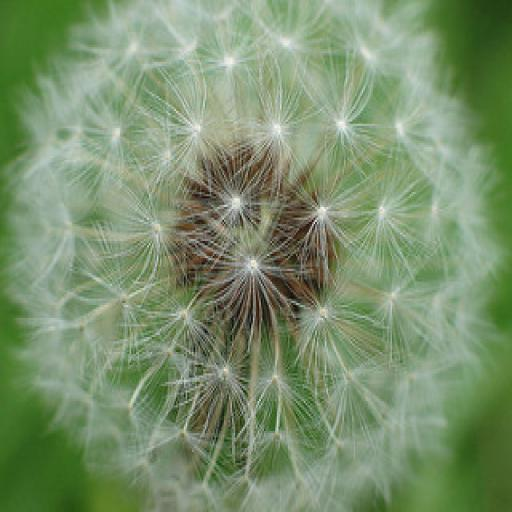

In [6]:
##-- Let's visualize an image --##
import random
from PIL import Image

random.seed(42)

# 1. Get all images paths (* means "any combination")
image_path_list = list(image_data_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Open the image
Image.open(random_image_path)

## 3. Transforming Data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming Using `torch.vision.transforms`

We have got images in our folder but we need to convert them into tensors so that we can input them into our model. For this we will be using `torch.vision.transforms`

In [9]:
##-- Image transformation code --##
image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)), # for tinyvgg
    transforms.RandomVerticalFlip(p=0.3),
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor()
])

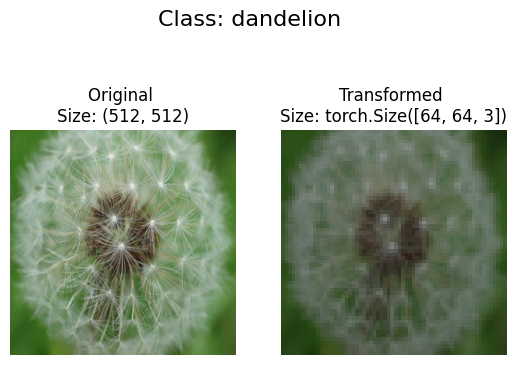

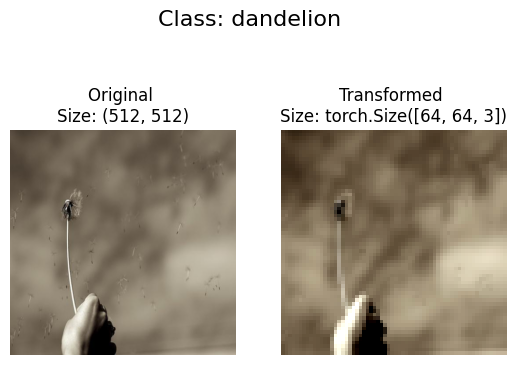

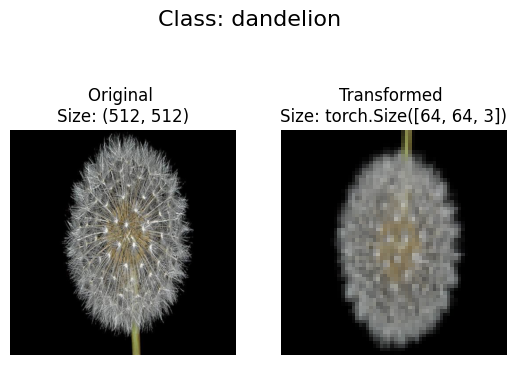

In [10]:
##-- Function to plot transformed images --##
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=image_transform,
                        n=3)

## 4. Loading Data Using `ImageFolder`

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=image_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=image_transform,
                                  target_transform=None)

In [12]:
train_data

Dataset ImageFolder
    Number of datapoints: 1275
    Root location: flower_data/flower_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.3)
               TrivialAugmentWide(num_magnitude_bins=10, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [13]:
test_data

Dataset ImageFolder
    Number of datapoints: 182
    Root location: flower_data/flower_dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.3)
               TrivialAugmentWide(num_magnitude_bins=10, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [14]:
# Get classes as a list
classes = train_data.classes
classes

['daisy', 'dandelion']

In [15]:
# Get classes as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'daisy': 0, 'dandelion': 1}

In [16]:
# Let's see one of the image from the train_data
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n{img}")
print(f"\nImage Shape:{img.shape}")
print(f"Image DataType:{img.dtype}")
print(f"Image Label:{label}")

Image Tensor:
tensor([[[0.5490, 0.5804, 0.5961,  ..., 0.6275, 0.5961, 0.5961],
         [0.5333, 0.5647, 0.6275,  ..., 0.6118, 0.5961, 0.5804],
         [0.5020, 0.5490, 0.5961,  ..., 0.6118, 0.5961, 0.5490],
         ...,
         [0.1412, 0.1569, 0.2196,  ..., 0.5020, 0.4863, 0.4863],
         [0.1569, 0.1725, 0.2039,  ..., 0.5176, 0.5020, 0.5020],
         [0.1725, 0.1725, 0.2039,  ..., 0.5333, 0.5176, 0.5020]],

        [[0.5490, 0.5804, 0.5961,  ..., 0.6275, 0.5961, 0.5961],
         [0.5333, 0.5647, 0.6275,  ..., 0.6118, 0.5961, 0.5804],
         [0.5020, 0.5490, 0.5961,  ..., 0.6118, 0.5961, 0.5490],
         ...,
         [0.1569, 0.1725, 0.2196,  ..., 0.4863, 0.4706, 0.4706],
         [0.1725, 0.1725, 0.2039,  ..., 0.5020, 0.4863, 0.4863],
         [0.1725, 0.1882, 0.2039,  ..., 0.5176, 0.5020, 0.4863]],

        [[0.5333, 0.5647, 0.5961,  ..., 0.6431, 0.5961, 0.5804],
         [0.5176, 0.5647, 0.6275,  ..., 0.6275, 0.5961, 0.5647],
         [0.4863, 0.5333, 0.5961,  ..., 0.61

### 4.1 Turn Loaded Images Into `DataLoaders`

In [18]:
##-- Turn train and test datasets into DataLoaders --##
import os
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7da617d6e530>,
 <torch.utils.data.dataloader.DataLoader at 0x7da61d1a6080>)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


## 5. TinyVGG Model

<img src="https://miro.medium.com/v2/resize:fit:1400/1*3ZkXJ-nIajuY3iX27w12aw.png" width="60%"/>

In [20]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [22]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 5.1 Training Loop

In [24]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### 5.1 Testing Loop

In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 5.3 Combine Both Training & Testing Loop

In [26]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 6. Model Evaluation

### 6.1 Model Training

In [27]:
len(train_data.classes)

2

In [28]:
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6902 | train_acc: 0.5577 | test_loss: 0.6776 | test_acc: 0.5990
Epoch: 2 | train_loss: 0.6833 | train_acc: 0.5775 | test_loss: 0.6733 | test_acc: 0.5990
Epoch: 3 | train_loss: 0.6803 | train_acc: 0.5842 | test_loss: 0.6733 | test_acc: 0.5990
Epoch: 4 | train_loss: 0.6790 | train_acc: 0.5880 | test_loss: 0.6811 | test_acc: 0.5990
Epoch: 5 | train_loss: 0.6785 | train_acc: 0.5822 | test_loss: 0.6616 | test_acc: 0.5990
Epoch: 6 | train_loss: 0.6641 | train_acc: 0.5811 | test_loss: 0.6580 | test_acc: 0.5990
Epoch: 7 | train_loss: 0.6595 | train_acc: 0.5888 | test_loss: 0.6185 | test_acc: 0.6615
Epoch: 8 | train_loss: 0.6475 | train_acc: 0.6108 | test_loss: 0.5680 | test_acc: 0.7118
Epoch: 9 | train_loss: 0.5851 | train_acc: 0.6895 | test_loss: 0.5069 | test_acc: 0.7708
Epoch: 10 | train_loss: 0.5649 | train_acc: 0.7361 | test_loss: 0.5197 | test_acc: 0.7604
Epoch: 11 | train_loss: 0.5318 | train_acc: 0.7583 | test_loss: 0.5162 | test_acc: 0.7604
Epoch: 12 | train_l

In [29]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 6.2 Plot Model Curves

In [30]:
def plot_loss_curves(results: dict[str, list[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

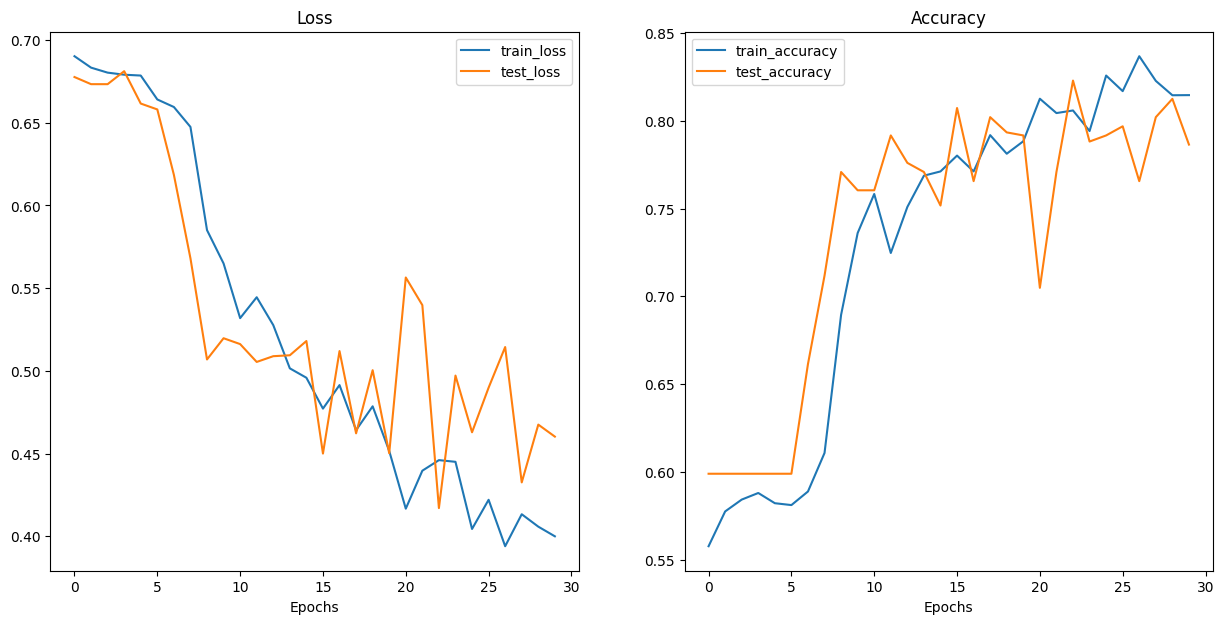

In [31]:
plot_loss_curves(model_0_results)

In [32]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.690191,0.557670,0.677606,0.598958
1,0.683289,0.577486,0.673298,0.598958
2,0.680268,0.584233,0.673292,0.598958
3,0.679015,0.587997,0.681144,0.598958
4,0.678508,0.582173,0.661574,0.598958
5,0.664053,0.581108,0.658018,0.598958
6,0.659488,0.588849,0.618495,0.661458
7,0.647451,0.610795,0.568039,0.711806
8,0.585058,0.689489,0.506862,0.770833
9,0.564898,0.736080,0.519692,0.760417
